In [3]:
!pip install apricot-select

     |████████████████████████████████| 61kB 6.9MB/s 
     |████████████████████████████████| 163kB 23.1MB/s 


In [4]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 11259464761440483968, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14638920512
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 5190286820990662021
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"]

In [5]:
import numpy as np
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch import nn
from torchvision import transforms
import torch
import torch.optim as optim
from torch.autograd import Variable
import sys
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from copy import deepcopy

from drive.MyDrive.distil.utils.DataHandler import DataHandler_Points
from drive.MyDrive.distil.active_learning_strategies import GLISTER,BADGE,EntropySampling
from drive.MyDrive.distil.utils.models.simpleNN_net import TwoLayerNet
from matplotlib import pyplot as plt

### **Loading data**
IJCNN1 is a binary classification Dataset with 49,990 samples and 22 features. The following code snippet can be used to read datasets in the svmlight / libsvm format into numpy arrays.

In [6]:
def libsvm_file_load(path,dim, save_data=False):
    data = []
    target = []
    with open(path) as fp:
       line = fp.readline()
       while line:
        temp = [i for i in line.strip().split(" ")]
        target.append(int(float(temp[0]))) # Class Number. # Not assumed to be in (0, K-1)
        temp_data = [0]*dim
        
        for i in temp[1:]:
            ind,val = i.split(':')
            temp_data[int(ind)-1] = float(val)
        data.append(temp_data)
        line = fp.readline()
    X_data = np.array(data,dtype=np.float32)
    Y_label = np.array(target)
    if save_data:
        # Save the numpy files to the folder where they come from
        data_np_path = path + '.data.npy'
        target_np_path = path + '.label.npy'
        np.save(data_np_path, X_data)
        np.save(target_np_path, Y_label)
    return (X_data, Y_label)

    
trn_file = 'drive/MyDrive/distil/datasets/ijcnn1/ijcnn1.trn'
val_file = 'drive/MyDrive/distil/datasets/ijcnn1/ijcnn1.val'
tst_file = 'drive/MyDrive/distil/datasets/ijcnn1/ijcnn1.tst'
data_dims = 22
num_cls = 2
x_trn, y_trn = libsvm_file_load(trn_file, dim=data_dims)
x_val, y_val = libsvm_file_load(val_file, dim=data_dims)
x_tst, y_tst = libsvm_file_load(tst_file, dim=data_dims)

# The class labels are (-1,1). Make them to (0,1)
y_trn[y_trn < 0] = 0
y_val[y_val < 0] = 0
y_tst[y_tst < 0] = 0    

sc = StandardScaler()
x_trn = sc.fit_transform(x_trn)
x_val = sc.transform(x_val)
x_tst = sc.transform(x_tst)


# **Class for training**

Although in this tutorial we mimic real world active learning setting with datasets which has all the labels, usually in a active learning settings it may take quite some time to label new set points. Therefore it is a good idea to create training class which can store current model state which can be restored later.

In [7]:
def init_weights(m):
    torch.manual_seed(42)
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

class data_train:

    def __init__(self, X, Y, net, handler, args):

        self.X = X
        self.Y = Y
        self.net = net
        self.handler = handler
        self.args = args
        self.use_cuda = torch.cuda.is_available()

    def update_index(self, idxs_lb):
        self.idxs_lb = idxs_lb

    def update_data(self, X, Y):
      
      self.X = X
      self.Y = Y
      self.n_pool = len(Y)

    def _train(self, epoch, loader_tr, optimizer):
        self.clf.train()
        accFinal = 0.

        for batch_id, (x, y, idxs) in enumerate(loader_tr):
            if self.use_cuda:
                x, y = Variable(x.cuda()), Variable(y.cuda())
            else:
                x, y = Variable(x), Variable(y)
            optimizer.zero_grad()
            out = self.clf(x)
            loss = F.cross_entropy(out, y)
            accFinal += torch.sum((torch.max(out,1)[1] == y).float()).data.item()
            loss.backward()

            # clamp gradients, just in case
            # for p in filter(lambda p: p.grad is not None, self.clf.parameters()): p.grad.data.clamp_(min=-.1, max=.1)

            optimizer.step()
        return accFinal / len(loader_tr.dataset.X)

    
    def train(self):

        print('Training..')
        def weight_reset(m):
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                m.reset_parameters()

        n_epoch = self.args['n_epoch']
        if self.use_cuda:
            self.clf =  self.net.apply(weight_reset).cuda()
        else:
            self.clf =  self.net.apply(weight_reset)

        optimizer = optim.Adam(self.clf.parameters(), lr = self.args['lr'], weight_decay=0)
        loader_tr = DataLoader(self.handler(self.X, self.Y, False),batch_size =1000)
        epoch = 1
        accCurrent = 0
        while accCurrent < 0.95 and epoch < n_epoch: 
            accCurrent = self._train(epoch, loader_tr, optimizer)
            epoch += 1
            # print(str(epoch) + ' training accuracy: ' + str(accCurrent), flush=True)
            
            if (epoch % 50 == 0) and (accCurrent < 0.2): # resetif not converging
                self.clf = self.net.apply(weight_reset)
                optimizer = optim.Adam(self.clf.parameters(), lr = self.args['lr'], weight_decay=0)

        print('Training accuracy:',round(accCurrent, 3)*100, flush=True) #'Epoch:', str(epoch),
        return self.clf

# **Trainig loop for active learning**

In [8]:
def training_round(strategy,dt,X_tr,Y_tr,X_unlabeled,Y_unlabeled,x_tst,y_tst,first=False):

    flag = False
    if first:

      nSamps, dim = np.shape(X_unlabeled)

      np.random.seed(42)
      start_idxs = np.random.choice(nSamps, size=int(0.01*nSamps), replace=False)

      X_tr = X_unlabeled[start_idxs]
      X_unlabeled = np.delete(X_unlabeled, start_idxs, axis = 0)

      Y_tr = Y_unlabeled[start_idxs]
      Y_unlabeled = np.delete(Y_unlabeled, start_idxs, axis = 0)

      print('Starting set of points -', len(start_idxs))

    else:    

      #Human In Loop, Assuming user adds new labels here
      idx = strategy.select(budget)
      
      #Adding new points to training set
      X_tr = np.concatenate((X_tr, X_unlabeled[idx]), axis=0)
      X_unlabeled = np.delete(X_unlabeled, idx, axis = 0)

      Y_tr = np.concatenate((Y_tr, Y_unlabeled[idx]), axis = 0)
      Y_unlabeled = np.delete(Y_unlabeled, idx, axis = 0)

      print('New data points added -', len(idx))
    
    strategy.update_data(X_tr, Y_tr, X_unlabeled)
    dt.update_data(X_tr, Y_tr)

    clf = dt.train()
    strategy.update_model(clf)
    y_pred = strategy.predict(x_tst).numpy()
    acc = round(1.0 * (y_tst == y_pred).sum().item() / len(y_tst), 3)
    #print('Testing accuracy:', acc, flush=True)
    if acc > 0.98:
        flag = True
        print('Testing accuracy reached above 98%')

    return X_tr,Y_tr,X_unlabeled,Y_unlabeled,acc, flag

# **Uncertanity based Active learning Strategy**

The most basic active learning strategy, where we select samples about which the model is most uncertain. To quantify the uncertainity we use entropy, therefore select points which have maximum entropy. Let $z_i$ be output from the model then the correponding softmax would be $$\sigma(z_i) = \frac{e^{z_i}}{\sum_j e^{z_j}}$$. Then entropy can be calculated as, $$ENTROPY = -\sum_j \sigma(z_j)*log(\sigma(z_i))$$

In [14]:
net = TwoLayerNet(data_dims, num_cls,40)
net.apply(init_weights)

strategy_args = {'batch_size' : 1000, 'lr':float(0.001)} 
strategy = EntropySampling(None, None, None, net, DataHandler_Points, num_cls, strategy_args)

args = {'n_epoch':100, 'lr':float(0.001)}  #Different args than strategy_args
n_rounds = 10    ##Number of rounds to run ac
budget = int(0.01*x_trn.shape[0])    ##Number of new data points after every iteration

#Training Class initialization
dt = data_train(None, None, net, DataHandler_Points, args)

un_acc = np.zeros(n_rounds+1)
X_unlabeled = deepcopy(x_trn)
Y_unlabeled = deepcopy(y_trn)
X_tr = None
Y_tr = None

X_tr,Y_tr,X_unlabeled,Y_unlabeled,un_acc[0],_ = training_round(strategy,dt,X_tr,Y_tr,X_unlabeled,Y_unlabeled,x_tst,y_tst,first=True)
print('Initial Testing accuracy:', round(un_acc[0], 3)*100, flush=True)

for i in range(n_rounds):
  X_tr,Y_tr,X_unlabeled,Y_unlabeled,un_acc[i+1],flag = training_round(strategy,dt,X_tr,Y_tr,X_unlabeled,Y_unlabeled,x_tst,y_tst)
  print('Testing accuracy at',i+1,'round :', round(un_acc[i+1], 3)*100, flush=True)  
  if flag:
    break


Starting set of points - 350
Training..
Training accuracy: 88.6
Initial Testing accuracy: 90.5
New data points added - 350
Training..
Training accuracy: 86.9
Testing accuracy at 1 round : 89.8
New data points added - 350
Training..
Training accuracy: 83.0
Testing accuracy at 2 round : 90.0
New data points added - 350
Training..
Training accuracy: 81.69999999999999
Testing accuracy at 3 round : 89.3
New data points added - 350
Training..
Training accuracy: 85.0
Testing accuracy at 4 round : 91.60000000000001
New data points added - 350
Training..
Training accuracy: 86.7
Testing accuracy at 5 round : 93.2
New data points added - 350
Training..
Training accuracy: 88.0
Testing accuracy at 6 round : 94.6
New data points added - 350
Training..
Training accuracy: 87.9
Testing accuracy at 7 round : 94.69999999999999
New data points added - 350
Training..
Training accuracy: 85.0
Testing accuracy at 8 round : 91.4
New data points added - 350
Training..
Training accuracy: 88.5
Testing accuracy at

# **GLISTER**
This is implemetation of GLISTER-ACTIVE from the paper [GLISTER: Generalization based Data Subset Selection for Efficient and Robust Learning](https://arxiv.org/abs/2012.10630). GLISTER methods tries to solve a bi-level optimisation problem.
\begin{equation*}
\overbrace{\underset{{S \subseteq {\mathcal U}, |S| \leq k}}{\operatorname{argmax\hspace{0.7mm}}} LL_V(\underbrace{\underset{\theta}{\operatorname{argmax\hspace{0.7mm}}} LL_T( \theta, S)}_{inner-level}, {\mathcal V})}^{outer-level}
\end{equation*}
where is $S$ is set of points selected at each round,${\mathcal V}$ could be a dedicated validation set with labled points or could be union of labeled and unlabeled points with hypothesised labels, $k$ is the budget.
To set ${\mathcal V}$ to be validation set, while calling **GLISTER** class in the toolkit set _valid=TRUE_ and pass validation set otherwise set _valid=False_.

Solving this problem directly is almost impossible, therefore we resort to one-step approxiations.We start we $S^0$ as empty set and bulid it as $S^k = S^{k-1} \cup e$, where $e$ is $\underset{e}{\operatorname{argmax\hspace{0.7mm}}} G_{\theta}(e | S^k)$. We define,$$G_{\theta}(e | S^k) = LL_{V}(\theta^{k}, {\mathcal V})$$ and update $$\theta^k \leftarrow \theta^{k-1} -  \eta \nabla_{\theta} LL_T(\hat{\theta}, e)$$ where $\hat{\theta}$ is the parameters of the model at the begining of the selection.
To prevent overfitting, we can add regularizer to GLISTER, which can be set by **_typeOf_**. **_typeOf_** can be set to - **'none'**(which is default) for normal GLISTER,**'Rand'** for replacing **_lam_** fraction of points by random points, **'Diversity'** adding diversity set function while computing gain and **'FacLoc'** adding Facility Location set function while computing gain. **_lam_** for both **'Diversity'** and **'FacLoc'** determines the weightage given to them while computing the gain.

In [18]:
net = TwoLayerNet(data_dims, num_cls,40)
net.apply(init_weights)

strategy_args = {'batch_size' : 12000, 'lr':float(0.001)} 
strategy = GLISTER(None, None, None, net, DataHandler_Points, num_cls, strategy_args,valid=False,typeOf='Diversity',lam=5)

args = {'n_epoch':100, 'lr':float(0.001)}  #Different args than strategy_args
n_rounds = 10    ##Number of rounds to run ac
budget = int(0.01*x_trn.shape[0])     ##Number of new data points after every iteration

#Training Class initialization
dt = data_train(None, None, net, DataHandler_Points, args)

glister_acc = np.zeros(n_rounds+1)
X_unlabeled = deepcopy(x_trn)
Y_unlabeled = deepcopy(y_trn)
X_tr = None
Y_tr = None

X_tr,Y_tr,X_unlabeled,Y_unlabeled,glister_acc[0],_ = training_round(strategy,dt,X_tr,Y_tr,X_unlabeled,Y_unlabeled,x_tst,y_tst,first=True)
print('Initial Testing accuracy:', round(glister_acc[0], 3)*100, flush=True)

for i in range(n_rounds):
  X_tr,Y_tr,X_unlabeled,Y_unlabeled,glister_acc[i+1],flag = training_round(strategy,dt,X_tr,Y_tr,X_unlabeled,Y_unlabeled,x_tst,y_tst)
  print('Testing accuracy at',i+1,'round :', round(glister_acc[i+1], 3)*100, flush=True)  
  if flag:
    break


Starting set of points - 350
Training..
Training accuracy: 88.6
Initial Testing accuracy: 90.5
New data points added - 350
Training..
Training accuracy: 88.4
Testing accuracy at 1 round : 86.6
New data points added - 350
Training..
Training accuracy: 84.3
Testing accuracy at 2 round : 88.0
New data points added - 350
Training..
Training accuracy: 90.10000000000001
Testing accuracy at 3 round : 90.7
New data points added - 350
Training..
Training accuracy: 88.4
Testing accuracy at 4 round : 92.4
New data points added - 350
Training..
Training accuracy: 86.5
Testing accuracy at 5 round : 92.9
New data points added - 350
Training..
Training accuracy: 87.6
Testing accuracy at 6 round : 91.60000000000001
New data points added - 350
Training..
Training accuracy: 88.3
Testing accuracy at 7 round : 95.1
New data points added - 350
Training..
Training accuracy: 86.8
Testing accuracy at 8 round : 94.89999999999999
New data points added - 350
Training..
Training accuracy: 87.2
Testing accuracy at

# **BADGE**
This method is based on the paper [Deep Batch Active Learning by Diverse, Uncertain Gradient Lower Bounds](https://arxiv.org/abs/1906.03671). Here at each around of selection loss gradients are computed using the hypothesised lables. Then to points to be labled are selected by applying k-means++ on these loss gradients. 

In [16]:
net = TwoLayerNet(data_dims, num_cls,40)
net.apply(init_weights)

strategy_args = {'batch_size' : 12000, 'lr':float(0.001)} 
strategy = BADGE(None, None, None, net, DataHandler_Points, num_cls, strategy_args)

args = {'n_epoch':100, 'lr':float(0.001)}  #Different args than strategy_args
n_rounds = 10    ##Number of rounds to run ac
budget = int(0.01*x_trn.shape[0])     ##Number of new data points after every iteration

#Training Class initialization
dt = data_train(None, None, net, DataHandler_Points, args)

badge_acc = np.zeros(n_rounds+1)
X_unlabeled = deepcopy(x_trn)
Y_unlabeled = deepcopy(y_trn)
X_tr = None
Y_tr = None

X_tr,Y_tr,X_unlabeled,Y_unlabeled,badge_acc[0],_ = training_round(strategy,dt,X_tr,Y_tr,X_unlabeled,Y_unlabeled,x_tst,y_tst,first=True)
print('Initial Testing accuracy:', round(badge_acc[0], 3)*100, flush=True)

for i in range(n_rounds):
  X_tr,Y_tr,X_unlabeled,Y_unlabeled,badge_acc[i+1],flag = training_round(strategy,dt,X_tr,Y_tr,X_unlabeled,Y_unlabeled,x_tst,y_tst)
  print('Testing accuracy at',i+1,'round :', round(badge_acc[i+1], 3)*100, flush=True)  
  if flag:
    break


Starting set of points - 350
Training..
Training accuracy: 88.6
Initial Testing accuracy: 90.5
New data points added - 350
Training..
Training accuracy: 85.6
Testing accuracy at 1 round : 91.0
New data points added - 350
Training..
Training accuracy: 89.8
Testing accuracy at 2 round : 91.3
New data points added - 350
Training..
Training accuracy: 88.6
Testing accuracy at 3 round : 91.7
New data points added - 350
Training..
Training accuracy: 86.1
Testing accuracy at 4 round : 91.7
New data points added - 350
Training..
Training accuracy: 86.0
Testing accuracy at 5 round : 92.4
New data points added - 350
Training..
Training accuracy: 87.8
Testing accuracy at 6 round : 93.8
New data points added - 350
Training..
Training accuracy: 88.1
Testing accuracy at 7 round : 93.7
New data points added - 350
Training..
Training accuracy: 89.2
Testing accuracy at 8 round : 94.6
New data points added - 350
Training..
Training accuracy: 89.2
Testing accuracy at 9 round : 94.89999999999999
New data p

Text(0.5, 1.0, 'IJCNN1')

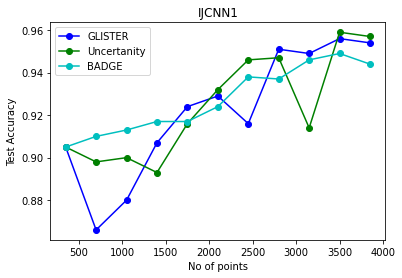

In [19]:
x_axis = np.array([budget for i in range(n_rounds+1)])
x_axis = x_axis*np.array([i for i in range(1,n_rounds+2)])
plt.figure()
plt.plot(x_axis, glister_acc, 'b-', label='GLISTER',marker='o')
plt.plot(x_axis, un_acc, 'g-', label='Uncertanity',marker='o')
plt.plot(x_axis, badge_acc, 'c', label='BADGE',marker='o')


plt.legend()
plt.xlabel('No of points')
plt.ylabel('Test Accuracy')
plt.title('IJCNN1')